# Source Detection Summary

Explore how many sources are detected as a function of, e.g., image quality, real/bogus score, etc.

## Connect to database

In [1]:
import psycopg2
import psycopg2.extras
import getpass
# from IPython.display import display
# import ipywidgets

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# import pandas as pd

from copy import deepcopy
import time

In [2]:
font = {'size' : 15}
mpl.rc('font', **font)

In [3]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")

DB User:  kennedyt
DB Password:  ············


In [4]:
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

In [5]:
db.autocommit = True # Makes the computer nicer about SQL syntax errors

In [6]:
cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

In [7]:
### If you want to print table schema
# tables = ['exposures','subtractions','objects','candidates']
# for table in tables:
#     query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name=%s"
#     cursor.execute( query, ( table, ))
#     print( f"\nTABLE: {table}\n===========================" )
#     for row in cursor:
#         print( f"{row['column_name']:24s}  :  {row['data_type']:s}" )

# tables = ['subtractions']
# for table in tables:
#     query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name=%s"
#     cursor.execute( query, ( table, ))
#     print( f"\nTABLE: {table}\n===========================" )
#     for row in cursor:
#         print( f"{row['column_name']:24s}  :  {row['data_type']:s}" )

## NOIRLab Archive Image List

Melissa made this list of all 2021A-0113 and 2021B-0149 images from the NOIRLab Data Archive.

In [8]:
fnm = 'archive_image_list.txt'
arch_fbase   = np.loadtxt( fnm, dtype='str', usecols=(0) )
arch_ra      = np.loadtxt( fnm, dtype='float', usecols=(1) )
arch_dec     = np.loadtxt( fnm, dtype='float', usecols=(2) )
arch_mjd     = np.loadtxt( fnm, dtype='float', usecols=(3) )
arch_filt    = np.loadtxt( fnm, dtype='str', usecols=(4) )
arch_airm    = np.loadtxt( fnm, dtype='float', usecols=(5) )
arch_obj     = np.loadtxt( fnm, dtype='str', usecols=(6) )
arch_expt    = np.loadtxt( fnm, dtype='float', usecols=(7) )
arch_seqid   = np.loadtxt( fnm, dtype='str', usecols=(8) )
arch_class   = np.loadtxt( fnm, dtype='str', usecols=(9) )
arch_ftype   = np.loadtxt( fnm, dtype='str', usecols=(10) )
arch_moonsep = np.loadtxt( fnm, dtype='float', usecols=(11) )
arch_moonill = np.loadtxt( fnm, dtype='float', usecols=(12) )
arch_mpval   = np.loadtxt( fnm, dtype='float', usecols=(13) )

In [9]:
np.unique(arch_class)

array(['COSMOS', 'COSMOS-AGN', 'COSMOS-MOON', 'DECaPS-East',
       'DECaPS-West', 'ELAIS', 'None'], dtype='<U11')

#### get rid of the DECaPS and non-standard archive images

In [10]:
tx = np.where( (arch_class != 'DECaPS-West') & (arch_class != 'DECaPS-East') )[0]
print('identified ',len(tx),' array elements to remove, out of ',len(arch_class))

arch_fbase   = np.delete( arch_fbase, tx )
arch_ra      = np.delete( arch_ra, tx )
arch_dec     = np.delete( arch_dec, tx )
arch_mjd     = np.delete( arch_mjd, tx )
arch_filt    = np.delete( arch_filt, tx )
arch_airm    = np.delete( arch_airm, tx )
arch_obj     = np.delete( arch_obj, tx )
arch_expt    = np.delete( arch_expt, tx )
arch_seqid   = np.delete( arch_seqid, tx )
arch_class   = np.delete( arch_class, tx )
arch_ftype   = np.delete( arch_ftype, tx )
arch_moonsep = np.delete( arch_moonsep, tx )
arch_moonill = np.delete( arch_moonill, tx )
arch_mpval   = np.delete( arch_mpval, tx )
del tx

print('new length of arch arrays = ',len(arch_fbase))

identified  2530  array elements to remove, out of  4579
new length of arch arrays =  2049


In [12]:
tx = np.where( ((arch_class == 'DECaPS-West') | (arch_class == 'DECaPS-East')) & (arch_mjd < 59400) )[0]
print( len(tx), np.nanmax(arch_mjd[tx]), np.nanmin(arch_mjd[tx]), np.nanmax(arch_mjd[tx])-np.nanmin(arch_mjd[tx]) )

824 59367.322858 59295.38441 71.93844800000079


## Exposures and Subtractions Tables

### exposures

In [13]:
query = "SELECT id, ra, dec, filename, mjd, filter, proposalid, header FROM exposures"
cursor.execute( query )
results = np.array( cursor.fetchall() ).transpose()
exp_id  = np.asarray( results[0], dtype='int' )
exp_ra  = np.asarray( results[1], dtype='float' )
exp_dec = np.asarray( results[2], dtype='float' )
exp_fnm = np.asarray( results[3], dtype='str' )
exp_mjd = np.asarray( results[4], dtype='float' )
exp_fil = np.asarray( results[5], dtype='str' )
exp_pid = np.asarray( results[6], dtype='str' )
exp_hdr = np.asarray( results[7], dtype='str' )
del query, results

In [14]:
### exp_fbs : just the filename base (without the extension)
### exp_cal : calendar date
exp_fbs = deepcopy(exp_fnm)
exp_cal = np.zeros( len(exp_fnm), dtype='int' )

for i,fnm in enumerate(exp_fnm):
    tmp1 = fnm.split('.')[0]
    exp_fbs[i] = tmp1
    tmp2 = tmp1.split('_')[1]
    exp_cal[i] = int(tmp2)
    del tmp1,tmp2

# print('fnm: ', exp_fnm[0])
# print('fbs: ',exp_fbs[0])
# print('cal: ',exp_cal[0])

#### get rid of non-DDF and non-standard exposures

In [15]:
### exp_aid : archive identifier (index in archive array)
exp_aid = np.zeros( len(exp_id), dtype='int' ) - 1

tag = 0
for i,fbase in enumerate(arch_fbase):
    tx = np.where( fbase == exp_fbs )[0]
    if len(tx) == 1:
        exp_aid[tx[0]] = i
    elif len(tx) > 1:
        exp_aid[tx[0]] = i
        tag += 1
    del tx

print(tag,' cases of double-matches, only the first will be kept')
del tag

0  cases of double-matches, only the first will be kept


In [16]:
tx = np.where( exp_aid == -1 )[0]
print('identified ',len(tx),' array elements to remove, out of ',len(exp_aid))

exp_id = np.delete( exp_id, tx )
exp_ra = np.delete( exp_ra, tx )
exp_dec = np.delete( exp_dec, tx )
exp_fnm = np.delete( exp_fnm, tx )
exp_mjd = np.delete( exp_mjd, tx )
exp_fil = np.delete( exp_fil, tx )
exp_pid = np.delete( exp_pid, tx )
exp_hdr = np.delete( exp_hdr, tx )
exp_fbs = np.delete( exp_fbs, tx )
exp_cal = np.delete( exp_cal, tx )
exp_aid = np.delete( exp_aid, tx )
del tx

print('new length of exp arrays = ',len(exp_id))

identified  5609  array elements to remove, out of  7640
new length of exp arrays =  2031


### subtractions

In [17]:
query = "SELECT id, ra, dec, lmt_mg, seeing, skysig, magzp, "+ \
        "ccdnum, image_id, exposure_id FROM subtractions"
cursor.execute( query )
results = np.array( cursor.fetchall() ).transpose()
sub_id  = np.asarray( results[0], dtype='int' )
sub_ra  = np.asarray( results[1], dtype='float' )
sub_dec = np.asarray( results[2], dtype='float' )
sub_lmg = np.asarray( results[3], dtype='float' )
sub_see = np.asarray( results[4], dtype='float' )
sub_sks = np.asarray( results[5], dtype='float' )
sub_mzp = np.asarray( results[6], dtype='float' )
sub_ccd = np.asarray( results[7], dtype='int' )
sub_iid = np.asarray( results[8], dtype='int' )
sub_eid = np.asarray( results[9], dtype='int' )
del query, results

#### get rid of subtractions that aren't matched to exposure table

In [18]:
### sub_expind : exposure table index
sub_expind = np.zeros( len(sub_id), dtype='int' ) - 1

tag = 0
for i in range(len(exp_id)):
    tx = np.where( exp_id[i] == sub_eid )[0]
    if len(tx) > 0:
        sub_expind[tx] = i
    else:
        tag += 1
    del tx

print(tag,' exposures had no subtractions')
del tag

96  exposures had no subtractions


In [19]:
tx = np.where( sub_expind == -1 )[0]
print('identified ',len(tx),' array elements to remove, out of ',len(sub_id))
sub_id  = np.delete(sub_id, tx)
sub_ra  = np.delete(sub_ra, tx)
sub_dec = np.delete(sub_dec, tx)
sub_lmg = np.delete(sub_lmg, tx)
sub_see = np.delete(sub_see, tx)
sub_sks = np.delete(sub_sks, tx)
sub_mzp = np.delete(sub_mzp, tx)
sub_ccd = np.delete(sub_ccd, tx)
sub_iid = np.delete(sub_iid, tx)
sub_eid = np.delete(sub_eid, tx)
sub_expind = np.delete(sub_expind, tx)

print('new length of sub arrays = ',len(sub_id))
del tx

identified  262182  array elements to remove, out of  378280
new length of sub arrays =  116098


## Objects and Candidates Tables

**objects** are the individual detections on a subtraction <br>
**candidates** are objects associated by location <br>

### objects

this query takes about 80 seconds

In [20]:
t1 = time.time()

query = ("SELECT o.id, o.ra, o.dec, o.candidate_id, o.subtraction_id, rbs.rb, o.mag, o.magerr, o.ignore FROM objects o "
         "JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 ")
cursor.execute( query )
results = np.array( cursor.fetchall() ).transpose()

t2 = time.time()
print(t2-t1)
del t1,t2

obj_id     = np.asarray( results[0], dtype='int' )
obj_ra     = np.asarray( results[1], dtype='float' )
obj_dec    = np.asarray( results[2], dtype='float' )
obj_candid = np.asarray( results[3] )
obj_subid  = np.asarray( results[4], dtype='int' )
obj_rb     = np.asarray( results[5], dtype='float' )
obj_mag    = np.asarray( results[6], dtype='float' )
obj_magerr = np.asarray( results[7], dtype='float' )
obj_ignore = np.asarray( results[8] )
del query, results

print(len(obj_id))

179.1905872821808
7712048


obj_ignore is always false

In [21]:
# print(obj_ignore)
# tx = np.where( obj_ignore == 'True' )[0]
# print(len(tx))
# del tx

#### get rid of objects that are not matched to a subtraction

In [22]:
### Check that all sub_id are unique (all lengths are the same)
values, indices, counts = np.unique( sub_id, return_inverse = True, return_counts = True )
print( 'sub_id lengths = ', len(values), len(indices), len(counts) )
print( values )
del values, indices, counts

### Note that obj_subid are not unique, of course
values, indices, counts = np.unique( obj_subid, return_inverse = True, return_counts = True )
print( 'obj_subid lengths = ', len(values), len(indices), len(counts) )
print( values )
del values, indices, counts

sub_id lengths =  116098 116098 116098
[339106 339107 339108 ... 455981 455982 455983]
obj_subid lengths =  364849 7712048 364849
[     1      2      3 ... 455981 455982 455983]


In [23]:
fout = open('deleteme.txt','w')

obj_subind = np.zeros( len(obj_subid), dtype='int' ) - 1
obj_fil = np.zeros( len(obj_subid), dtype='str' )
obj_mjd = np.zeros( len(obj_subid), dtype='float' )

sub_nobj = np.zeros( len(sub_id), dtype='int' )
sub_nobjg = np.zeros( len(sub_id), dtype='int' )

ssx = np.argsort( sub_id )
ossx = np.argsort( obj_subid )

t1 = time.time()

j = 0
for i in range(len(ssx)):
    cntr = 0
    cntrg = 0
    
    if (i == 1000) | (i == 10000):
        timeleft = ((time.time()-t1)/float(i)) * (len(sub_id)-float(i))
        print('TIMER: i=',i,'  this will take another ',timeleft,' seconds')
        del timeleft
    
    next_sub = False
    while (next_sub == False) & (j < len(ossx)):
        if sub_id[ssx[i]] > obj_subid[ossx[j]]:
            fout.write('%1s %10i %10i %10s %10i %10i %6i %6i \n' %\
                       ('A', i, j, next_sub, sub_id[ssx[i]], obj_subid[ossx[j]], cntr, cntrg) )
            j += 1
        elif sub_id[ssx[i]] == obj_subid[ossx[j]]:
            cntr += 1
            if obj_rb[ossx[j]] > 0.6:
                cntrg += 1
            obj_subind[ossx[j]] = ssx[i]
            obj_fil[ossx[j]] = exp_fil[sub_expind[ssx[i]]]
            obj_mjd[ossx[j]] = exp_mjd[sub_expind[ssx[i]]]
            
            fout.write('%1s %10i %10i %10s %10i %10i %6i %6i \n' %\
                       ('B', i, j, next_sub, sub_id[ssx[i]], obj_subid[ossx[j]], cntr, cntrg) )
            j += 1
        elif sub_id[ssx[i]] < obj_subid[ossx[j]]:
            next_sub = True
            fout.write('%1s %10i %10i %10s %10i %10i %6i %6i \n' %\
                       ('C', i, j, next_sub, sub_id[ssx[i]], obj_subid[ossx[j]], cntr, cntrg) )

    sub_nobj[ssx[i]] = cntr
    sub_nobjg[ssx[i]] = cntrg
    del cntr, cntrg

fout.close()
print('wrote to deleteme.txt')

del i, j, ssx, ossx

t2 = time.time()
print('elapsed: ',t2-t1)
del t1,t2

TIMER: i= 1000   this will take another  1372.0697572202682  seconds
TIMER: i= 10000   this will take another  161.8056929872513  seconds
wrote to deleteme.txt
elapsed:  39.82141590118408


In [24]:
os.system('rm deleteme.txt')

0

now actually remove the elements of the objects array

In [25]:
tx = np.where( obj_subind < 0 )[0]
print('identified ',len(tx),' array elements to remove, out of ',len(obj_subind))

obj_id     = np.delete( obj_id, tx )
obj_ra     = np.delete( obj_ra, tx )
obj_dec    = np.delete( obj_dec, tx )
obj_candid = np.delete( obj_candid, tx )
obj_subid  = np.delete( obj_subid, tx )
obj_rb     = np.delete( obj_rb, tx )
obj_mag    = np.delete( obj_mag, tx )
obj_magerr = np.delete( obj_magerr, tx )
obj_ignore = np.delete( obj_ignore, tx )
obj_subind = np.delete( obj_subind, tx )
obj_fil    = np.delete( obj_fil, tx )
obj_mjd    = np.delete( obj_mjd, tx )

print('new length of obj arrays = ',len(obj_id))
del tx

identified  3641203  array elements to remove, out of  7712048
new length of obj arrays =  4070845


#### get rid of objects that are duplicates

they are within 0.1" of another object in the same subtraction <br>
this takes about 3 minutes <br>

In [26]:
t1 = time.time()

obj_dup = np.zeros( len(obj_id), dtype='int' )

limit = (0.1 / 3600.0)**2

tcntr = 0
scntr = 0
for s,subid in enumerate(sub_id):
    
    if (s==100) | (s==1000) | (s==10000) | (s==30000) | (s==60000):
        t2 = time.time()
        rtime = ( (t2-t1) / float(s) ) * ( float(len(sub_id)) - float(s) )
        print( 's = ', s, np.round(rtime,1), ' seconds remain.' )
        del t2,rtime
    
    tx = np.where( obj_subid == subid )[0]

    if len(tx) > 0:
        cntr = 0
        cntrg = 0

        stx = np.argsort( obj_ra[tx] )

        pra = obj_ra[tx[stx[0]]]
        pde = obj_dec[tx[stx[0]]]
        for i in range(len(tx)):
            if i > 0:
                nra = obj_ra[tx[stx[i]]]
                nde = obj_dec[tx[stx[i]]]
                off = (nra-pra)**2 + (nde-pde)**2
                if off < limit:
                    obj_dup[tx[stx[i]]] = 1
                    cntr += 1
                    tcntr += 1
                    if obj_rb[tx[stx[i]]] > 0.6:
                        cntrg += 1
                else:
                    pra = nra
                    pde = nde
                del nra,nde,off

        sub_nobj[s] -= cntr
        sub_nobjg[s] -= cntrg
    
    else:
        scntr += 1
    

t2 = time.time()
print( 'Done, took: ', t2-t1, ' seconds total.')
del t1,t2

tx = np.where( obj_dup == 1 )[0]
print('total number of duplicates identified: ',len(tx))
print('should match: ',tcntr)
del tx,tcntr

print(scntr, 'subs had no objs')
del scntr

s =  100 542.0  seconds remain.
s =  1000 498.6  seconds remain.
s =  10000 472.9  seconds remain.
s =  30000 374.8  seconds remain.
s =  60000 245.9  seconds remain.
Done, took:  505.29269909858704  seconds total.
total number of duplicates identified:  9755
should match:  9755
5455 subs had no objs


In [27]:
tx = np.where( obj_dup == 1 )[0]
print('identified ',len(tx),' array elements to remove, out of ',len(obj_subind))

obj_id     = np.delete( obj_id, tx )
obj_ra     = np.delete( obj_ra, tx )
obj_dec    = np.delete( obj_dec, tx )
obj_candid = np.delete( obj_candid, tx )
obj_subid  = np.delete( obj_subid, tx )
obj_rb     = np.delete( obj_rb, tx )
obj_mag    = np.delete( obj_mag, tx )
obj_magerr = np.delete( obj_magerr, tx )
obj_ignore = np.delete( obj_ignore, tx )
obj_subind = np.delete( obj_subind, tx )
obj_fil    = np.delete( obj_fil, tx )
obj_mjd    = np.delete( obj_mjd, tx )

print('new length of obj arrays = ',len(obj_id))
del tx, obj_dup

identified  9755  array elements to remove, out of  4070845
new length of obj arrays =  4061090


#### update the exposures table with subtraction data

In [28]:
### mean limiting magnitudes, seeing, and sky background
exp_mlmg = np.zeros( len(exp_id), dtype='float')
exp_msee = np.zeros( len(exp_id), dtype='float')
exp_msks = np.zeros( len(exp_id), dtype='float')

### total number of objects, and good objects with R/B>0.6
exp_tnobj = np.zeros( len(exp_id), dtype='float')
exp_tnobjg = np.zeros( len(exp_id), dtype='float')

t1 = time.time()

for e,expid in enumerate(exp_id):
    if (e == 100) | (e == 1000) | (e == 10000):
        t2 = time.time()
        print('time remaining: ', ((t2-t1)/float(e))*(float(len(exp_id))-float(e)) )
    tx = np.where( sub_eid == expid )[0]
    exp_mlmg[e] = np.mean( sub_lmg[tx] )
    exp_msee[e] = np.mean( sub_see[tx] )
    exp_msks[e] = np.mean( sub_sks[tx] )
    exp_tnobj[e] = np.sum( sub_nobj[tx] )
    exp_tnobjg[e] = np.sum( sub_nobjg[tx] )
    del tx

t3 = time.time()
print('done, ',t3-t1,' elapsed')
del t1,t2,t3

time remaining:  0.4323303365707397
time remaining:  0.18008106327056886


/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


done,  0.30862998962402344  elapsed


### candidates

this query takes about 30 seconds

In [29]:
t1 = time.time()

# query = "SELECT id, ra, dec, nmatches FROM candidates"
query = "SELECT id, ra, dec FROM candidates"
cursor.execute( query )
results = np.array( cursor.fetchall() ).transpose()

t2 = time.time()
print(t2-t1)
del t1,t2

cand_id       = np.asarray( results[0] )
cand_ra       = np.asarray( results[1], dtype='float' )
cand_dec      = np.asarray( results[2], dtype='float' )
# cand_nmatches = np.asarray( results[3] )
del query, results

print(len(cand_id))

35.64504051208496
3076654


In [30]:
### Check that all cand_id are unique (all lengths are the same)
values, indices, counts = np.unique( cand_id, return_inverse = True, return_counts = True )
print( 'lengths = ', len(values), len(indices), len(counts) )
del values, indices, counts

lengths =  3076654 3076654 3076654


#### get rid of candidates that are not matched to an object

this process takes about 4 seconds

In [31]:
values, indices, counts = np.unique( obj_candid, return_inverse = True, return_counts = True )
print( 'lengths = ', len(values), len(indices), len(counts) )
print( 'values = ', values )
print( 'indices = ', indices )
print( 'counts = ', counts )
print( ' ' )

t1 = time.time()

cand_nobj = np.zeros( len(cand_id), dtype='int' ) - 1

sx = np.argsort( cand_id )
cntr = 0
for c,val in enumerate( values ):
    match = False
    while match == False:
        if val == cand_id[sx[cntr]]:
            cand_nobj[sx[cntr]] = counts[c]
            cntr += 1
            match = True
        else:
            cntr += 1
    del match
del cntr,sx

t2 = time.time()
print(t2-t1)
del t1,t2

del values, indices, counts

lengths =  1227660 4061090 1227660
values =  ['DC21baaab' 'DC21baaad' 'DC21baaag' ... 'DC22gtbny' 'DC22gtbnz'
 'DC22gtboa']
indices =  [1227654 1227653 1227649 ...  231364  231344  231340]
counts =  [1 1 2 ... 1 1 1]
 
5.657290458679199


In [32]:
### That was really fast; double check.

# tx = np.where( cand_nobj <= 0 )[0]
# print(len(tx),' candidates are NOT matched to an object, out of ',len(cand_nobj))
# for i in range(10):
#     rx = np.where( obj_candid == cand_id[tx[i]] )[0]
#     print( cand_id[tx[i]], len(rx) )
#     del rx
# del tx

# tx = np.where( cand_nobj > 0 )[0]
# print(len(tx),' candidates ARE matched to an object, out of ',len(cand_nobj))
# for i in range(10):
#     rx = np.where( obj_candid == cand_id[tx[i]] )[0]
#     print( cand_id[tx[i]], len(rx) )
#     del rx
# del tx

In [33]:
tx = np.where( cand_nobj <= 0 )[0]
cand_id   = np.delete( cand_id, tx )
cand_ra   = np.delete( cand_ra, tx )
cand_dec  = np.delete( cand_dec, tx )
cand_nobj = np.delete( cand_nobj, tx )

print('new length of cand arrays = ',len(cand_id))
del tx

new length of cand arrays =  1227660


### calculate candidate qualities

mean real/bogus score <br>
time span (max-min date) <br>
lightcurve amplitude (max-min mag) <br>

this takes about 1 minute

In [34]:
t1 = time.time()

csx = np.argsort(cand_id)
osx = np.argsort(obj_candid)

cand_meanrb = np.zeros( len(cand_id), dtype='float' )
cand_stdrb = np.zeros( len(cand_id), dtype='float' )
cand_tspan = np.zeros( len(cand_id), dtype='float' )
cand_lcamp = np.zeros( len(cand_id), dtype='float' )

cand_meanrb_f = np.zeros( (len(cand_id),3), dtype='float' )
cand_stdrb_f = np.zeros( (len(cand_id),3), dtype='float' )
cand_tspan_f = np.zeros( (len(cand_id),3), dtype='float' )
cand_lcamp_f = np.zeros( (len(cand_id),3), dtype='float' )
cand_nobj_f = np.zeros( (len(cand_id),3), dtype='int' )

j = 0
for i,x in enumerate(csx):
    if (i==100) | (i==10000) | (i==100000):
        elt = time.time()-t1
        print('Time remaining:', (elt/float(i)) * float(len(cand_id)-float(i)) )
    
    if cand_id[x] == obj_candid[osx[j]]:
        match = True
        # temp = []
        ti = []
        tig = []
        tir = []
        tii = []

        while match == True:
            fillarrays = False
            
            if j < len(obj_candid):
            
                if cand_id[x] == obj_candid[osx[j]]:
                    # temp.append( obj_rb[osx[j]] )
                    
                    ti.append(osx[j])
                    if obj_fil[osx[j]] == 'g':
                        tig.append(osx[j])
                    elif obj_fil[osx[j]] == 'r':
                        tir.append(osx[j])
                    elif obj_fil[osx[j]] == 'i':
                        tii.append(osx[j])
                        
                    j += 1
                
                elif cand_id[x] != obj_candid[osx[j]]:
                    match = False
                    fillarrays = True
                    # cand_meanrb[x,0] = np.mean( np.asarray( temp, dtype='float' ) )
                    
            else:
                match = False
                fillarrays = True
                # cand_meanrb[x] = np.mean( np.asarray( temp, dtype='float' ) )
            
            if fillarrays == True:
                if len(ti) > 0:
                    ind_ti = np.asarray( ti, dtype='int' )
                    cand_meanrb[x] = np.nanmean(obj_rb[ind_ti])
                    cand_stdrb[x] = np.nanstd(obj_rb[ind_ti])
                    cand_tspan[x] = np.nanmax(obj_mjd[ind_ti]) - np.nanmin(obj_mjd[ind_ti])
                    cand_lcamp[x] = np.nanmax(obj_mag[ind_ti]) - np.nanmin(obj_mag[ind_ti])
                    del ind_ti
                    if len(tig) > 0:
                        ind_tig = np.asarray( tig, dtype='int' )
                        cand_meanrb_f[x,0] = np.nanmean(obj_rb[ind_tig])
                        cand_stdrb_f[x,0] = np.nanstd(obj_rb[ind_tig])
                        cand_tspan_f[x,0] = np.nanmax(obj_mjd[ind_tig]) - np.nanmin(obj_mjd[ind_tig])
                        cand_lcamp_f[x,0] = np.nanmax(obj_mag[ind_tig]) - np.nanmin(obj_mag[ind_tig])
                        cand_nobj_f[x,0] = len(tig)
                        del ind_tig
                    if len(tir) > 0:
                        ind_tir = np.asarray( tir, dtype='int' )
                        cand_meanrb_f[x,1] = np.nanmean(obj_rb[ind_tir])
                        cand_stdrb_f[x,1] = np.nanstd(obj_rb[ind_tir])
                        cand_tspan_f[x,1] = np.nanmax(obj_mjd[ind_tir]) - np.nanmin(obj_mjd[ind_tir])
                        cand_lcamp_f[x,1] = np.nanmax(obj_mag[ind_tir]) - np.nanmin(obj_mag[ind_tir])
                        cand_nobj_f[x,1] = len(tir)
                        del ind_tir
                    if len(tii) > 0:
                        ind_tii = np.asarray( tii, dtype='int' )
                        cand_meanrb_f[x,2] = np.nanmean(obj_rb[ind_tii])
                        cand_stdrb_f[x,2] = np.nanstd(obj_rb[ind_tii])
                        cand_tspan_f[x,2] = np.nanmax(obj_mjd[ind_tii]) - np.nanmin(obj_mjd[ind_tii])
                        cand_lcamp_f[x,2] = np.nanmax(obj_mag[ind_tii]) - np.nanmin(obj_mag[ind_tii])
                        cand_nobj_f[x,2] = len(tii)
                        del ind_tii

        # del temp
        del ti,tig,tir,tii
        del match
        
t2 = time.time()
print('Time elapsed: ',t2-t1)
del t1,t2

del csx, osx

Time remaining: 44022.809387111665
Time remaining: 985.6745516204834
Time remaining: 550.3142752932072


/tmp/ipykernel_22635/1053590115.py:88: RuntimeWarning: All-NaN slice encountered
  cand_lcamp_f[x,2] = np.nanmax(obj_mag[ind_tii]) - np.nanmin(obj_mag[ind_tii])
/tmp/ipykernel_22635/1053590115.py:72: RuntimeWarning: All-NaN slice encountered
  cand_lcamp_f[x,0] = np.nanmax(obj_mag[ind_tig]) - np.nanmin(obj_mag[ind_tig])
/tmp/ipykernel_22635/1053590115.py:65: RuntimeWarning: All-NaN slice encountered
  cand_lcamp[x] = np.nanmax(obj_mag[ind_ti]) - np.nanmin(obj_mag[ind_ti])
/tmp/ipykernel_22635/1053590115.py:80: RuntimeWarning: All-NaN slice encountered
  cand_lcamp_f[x,1] = np.nanmax(obj_mag[ind_tir]) - np.nanmin(obj_mag[ind_tir])


Time elapsed:  570.337456703186


<br>
<br>
<br>

# Plots

In [35]:
### DECAPS-West g, r, i, ELAIS g, r, i
c = ['darkgreen', 'firebrick', 'saddlebrown', 'limegreen', 'orange', 'lightcoral']

### DECAPS-West, DECAPS-East
cc = 'dodgerblue'
ce = 'darkviolet'

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

<br>
<br>

## plot exposure qualities

In [36]:
DWex = np.where( (exp_ra > 100.0) & (exp_ra < 130.0) & (exp_dec > -30.0)  & (exp_dec < -20.0) )[0]
DEex = np.where( (exp_ra > 250.0)   & (exp_ra < 300.0)  & (exp_dec > -35.0) & (exp_dec < -25.0) )[0]
print('Number of DECAPS-West exposures: ',len(DWex))
print('Number of DECAPS-East exposures: ',len(DEex))
print(len(DWex)+len(DEex),' should equal ',len(exp_ra))

tx = np.where( exp_tnobj < 1 )[0]
print('Number of exposures with no objects: ',len(tx))
del tx

tx = np.where( exp_tnobjg < 1 )[0]
print('Number of exposures with no good objects: ',len(tx))
del tx

Number of DECAPS-West exposures:  1015
Number of DECAPS-East exposures:  1016
2031  should equal  2031
Number of exposures with no objects:  98
Number of exposures with no good objects:  101


In [37]:
exp_moonsep = arch_moonsep[ exp_aid ]
exp_moonill = arch_moonill[ exp_aid ]

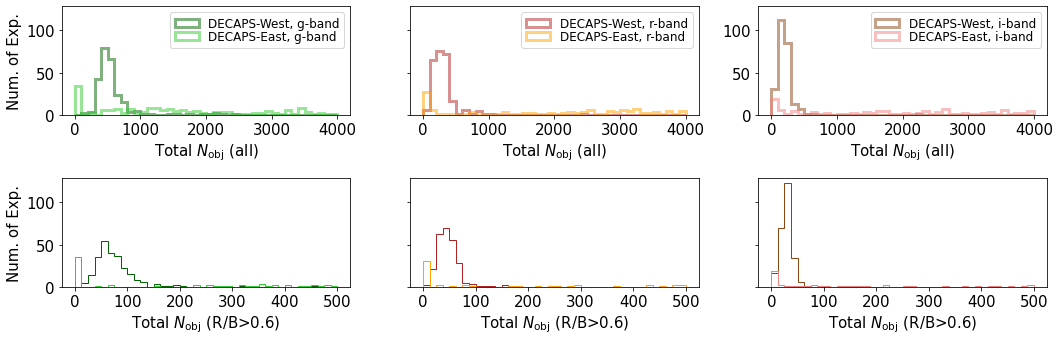

In [38]:
fig, ax = plt.subplots( 2, 3, figsize=(15,5), sharey=True )

ax[0,0].set_ylabel('Num. of Exp.')
ax[1,0].set_ylabel('Num. of Exp.')

for i,ifilt in enumerate(['g','r','i']):
    DWfx = np.where( exp_fil[DWex] == ifilt )[0]
    DEfx = np.where( exp_fil[DEex] == ifilt )[0]
    j = i + 3
    ax[0,i].hist( exp_tnobj[DWex[DWfx]], bins=40, range=(0,4000), histtype='step', lw=3, alpha=0.5, \
                 color=c[i], label='DECAPS-West, '+ifilt+'-band')
    ax[0,i].hist( exp_tnobj[DEex[DEfx]], bins=40, range=(0,4000), histtype='step', lw=3, alpha=0.5, \
                 color=c[j], label='DECAPS-East, '+ifilt+'-band')
    ax[0,i].set_xlabel(r'Total $N_{\rm obj}$ (all)')
    # ax[0,i].set_xlim([20,25])
    ax[0,i].legend(loc='upper right', labelspacing=0, fontsize=12)

for i,ifilt in enumerate(['g','r','i']):
    DWfx = np.where( exp_fil[DWex] == ifilt )[0]
    DEfx = np.where( exp_fil[DEex] == ifilt )[0]
    j = i + 3
    ax[1,i].hist( exp_tnobjg[DWex[DWfx]], bins=40, range=(0,500), histtype='step', lw=1, color=c[i])
    ax[1,i].hist( exp_tnobjg[DEex[DEfx]], bins=40, range=(0,500), histtype='step', lw=1, color=c[j])
    ax[1,i].set_xlabel(r'Total $N_{\rm obj}$ (R/B>0.6)')
    # ax[1,i].set_xlim([20,25])

ax[0,i].yaxis.set_tick_params(which='both', labelbottom=True)
# ax[1,i].yaxis.set_tick_params(which='both', labelbottom=True)

fig.tight_layout()
plt.show()

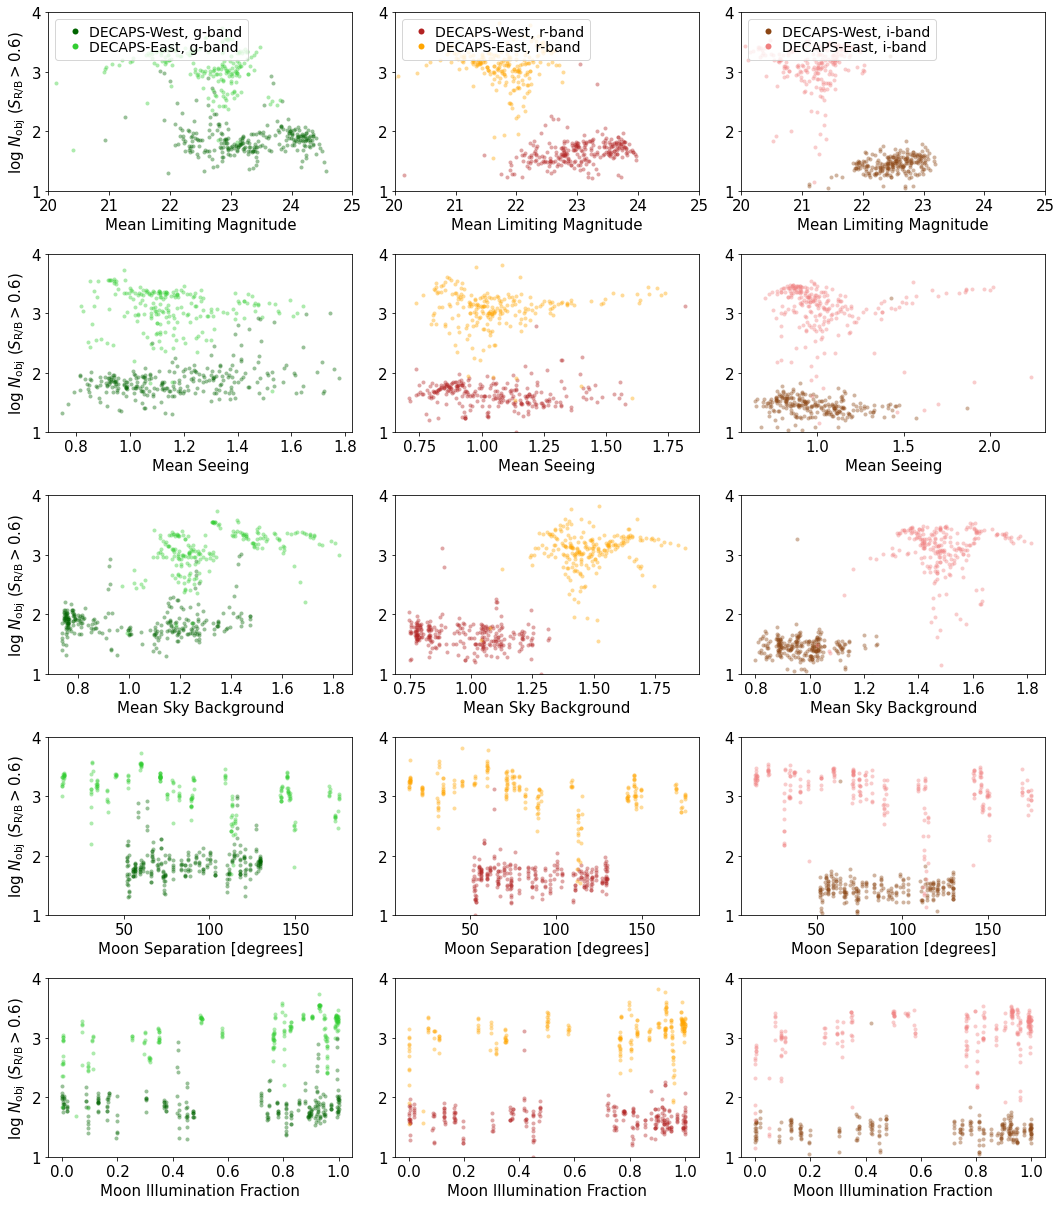

In [39]:
fig, ax = plt.subplots( 5, 3, figsize=(15,17), sharey=True )

for row in range(5):
    for i,ifilt in enumerate(['g','r','i']):
        DWfx = np.where( (exp_fil[DWex] == ifilt) & (exp_tnobjg[DWex]>0) )[0]
        DEfx = np.where( (exp_fil[DEex] == ifilt) & (exp_tnobjg[DEex]>0) )[0]
        j = i + 3

        if row == 0:
            ax[row,i].plot( exp_mlmg[DWex[DWfx]], np.log10(exp_tnobjg[DWex[DWfx]]), 'o', ms=4, alpha=0.4, mew=0, color=c[i])
            ax[row,i].plot( exp_mlmg[DEex[DEfx]], np.log10(exp_tnobjg[DEex[DEfx]]), 'o', ms=4, alpha=0.4, mew=0, color=c[j])
            ax[row,i].set_xlabel("Mean Limiting Magnitude")
            ax[row,i].set_xlim([20,25])            
            ax[row,i].plot( -99, -99, 'o', ms=6, alpha=1, mew=0, color=c[i], label='DECAPS-West, '+ifilt+'-band')
            ax[row,i].plot( -99, -99, 'o', ms=6, alpha=1, mew=0, color=c[j], label='DECAPS-East, '+ifilt+'-band')
            ax[row,i].legend(loc='upper left', handletextpad=0, labelspacing=0.1, fontsize=14)
        if row == 1:
            ax[row,i].plot( exp_msee[DWex[DWfx]], np.log10(exp_tnobjg[DWex[DWfx]]), 'o', ms=4, alpha=0.4, mew=0, color=c[i])
            ax[row,i].plot( exp_msee[DEex[DEfx]], np.log10(exp_tnobjg[DEex[DEfx]]), 'o', ms=4, alpha=0.4, mew=0, color=c[j])
            ax[row,i].set_xlabel("Mean Seeing")
            # ax[row,i].set_xlim([0.5,2.5])
        if row == 2:
            ax[row,i].plot( np.log10(exp_msks[DWex[DWfx]]), np.log10(exp_tnobjg[DWex[DWfx]]), 'o', ms=4, alpha=0.4, mew=0, color=c[i])
            ax[row,i].plot( np.log10(exp_msks[DEex[DEfx]]), np.log10(exp_tnobjg[DEex[DEfx]]), 'o', ms=4, alpha=0.4, mew=0, color=c[j])
            ax[row,i].set_xlabel("Mean Sky Background")
            # ax[row,i].set_xlim([0,2.5])
        if row == 3:
            ax[row,i].plot( exp_moonsep[DWex[DWfx]], np.log10(exp_tnobjg[DWex[DWfx]]), 'o', ms=4, alpha=0.4, mew=0, color=c[i])
            ax[row,i].plot( exp_moonsep[DEex[DEfx]], np.log10(exp_tnobjg[DEex[DEfx]]), 'o', ms=4, alpha=0.4, mew=0, color=c[j])
            ax[row,i].set_xlabel("Moon Separation [degrees]")
            # ax[row,i].set_xlim([0,5000])
        if row == 4:
            ax[row,i].plot( exp_moonill[DWex[DWfx]], np.log10(exp_tnobjg[DWex[DWfx]]), 'o', ms=4, alpha=0.4, mew=0, color=c[i])
            ax[row,i].plot( exp_moonill[DEex[DEfx]], np.log10(exp_tnobjg[DEex[DEfx]]), 'o', ms=4, alpha=0.4, mew=0, color=c[j])
            ax[row,i].set_xlabel("Moon Illumination Fraction")
            # ax[row,i].set_xlim([0,5000])
        # if row == 5:
        #     ax[row,i].plot( exp_mjd[DWex[DWfx]], np.log10(exp_tnobjg[DWex[DWfx]]), 'o', ms=4, alpha=0.2, mew=0, color=c[i])
        #     ax[row,i].plot( exp_mjd[DEex[DEfx]], np.log10(exp_tnobjg[DEex[DEfx]]), 'o', ms=4, alpha=0.2, mew=0, color=c[j])
        #     ax[row,i].set_xlabel("MJD")
        # if row == 6:
        #     ax[row,i].plot( exp_tnobj[DWex[DWfx]], np.log10(exp_tnobjg[DWex[DWfx]]), 'o', ms=4, alpha=0.2, mew=0, color=c[i])
        #     ax[row,i].plot( exp_tnobj[DEex[DEfx]], np.log10(exp_tnobjg[DEex[DEfx]]), 'o', ms=4, alpha=0.2, mew=0, color=c[j])
        #     ax[row,i].set_xlabel("Number of Objects (all)")
        #     ax[row,i].set_xlim([0,5000])

        ax[row,i].yaxis.set_tick_params(which='both', labelbottom=True)
        if i == 0:
            ax[row,i].set_ylabel(r'log $N_{\rm obj}$ ($S_{\rm R/B}>0.6$)')
        ax[row,i].set_ylim([1,4])

        del DWfx,DEfx,j
    
fig.tight_layout()
plt.savefig('gal_sds_figures/srcdet_nobjimg')
# plt.show()

In [40]:
#### for when you need to check for exps/subs with too many objects

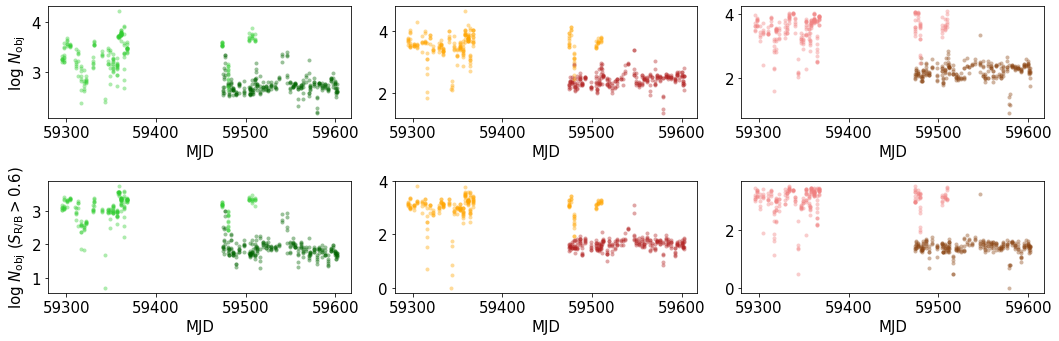

In [41]:
fig, ax = plt.subplots( 2, 3, figsize=(15,5), sharey=False )
for row in range(2):
    for i,ifilt in enumerate(['g','r','i']):
        DWfx = np.where( (exp_fil[DWex] == ifilt) & (exp_tnobjg[DWex]>0) )[0]
        DEfx = np.where( (exp_fil[DEex] == ifilt) & (exp_tnobjg[DEex]>0) )[0]
        j = i + 3
        if row == 0:
            ax[row,i].plot( exp_mjd[DWex[DWfx]], np.log10(exp_tnobj[DWex[DWfx]]), 'o', ms=4, alpha=0.4, mew=0, color=c[i])
            ax[row,i].plot( exp_mjd[DEex[DEfx]], np.log10(exp_tnobj[DEex[DEfx]]), 'o', ms=4, alpha=0.4, mew=0, color=c[j])
            ax[row,i].set_xlabel("MJD")
            # ax[row,i].set_xlim([20,25])            
            # ax[row,i].plot( -99, -99, 'o', ms=6, alpha=1, mew=0, color=c[i], label='DECAPS-West, '+ifilt+'-band')
            # ax[row,i].plot( -99, -99, 'o', ms=6, alpha=1, mew=0, color=c[j], label='ELAIS, '+ifilt+'-band')
            # ax[row,i].legend(loc='upper left', handletextpad=0, labelspacing=0.1, fontsize=14)
        if row == 1:
            ax[row,i].plot( exp_mjd[DWex[DWfx]], np.log10(exp_tnobjg[DWex[DWfx]]), 'o', ms=4, alpha=0.4, mew=0, color=c[i])
            ax[row,i].plot( exp_mjd[DEex[DEfx]], np.log10(exp_tnobjg[DEex[DEfx]]), 'o', ms=4, alpha=0.4, mew=0, color=c[j])
            ax[row,i].set_xlabel("MJD")
            # ax[row,i].set_xlim([0.5,2.5])
        ax[row,i].yaxis.set_tick_params(which='both', labelbottom=True)
        del DWfx,DEfx,j

# for row in range(2):
#     for i,ifilt in enumerate(['g','r','i']):
        # ax[row,i].set_xlim([59504.05,59504.2])
        # ax[row,i].set_xlim([59500,59550])

ax[0,0].set_ylabel(r'log $N_{\rm obj}$')
ax[1,0].set_ylabel(r'log $N_{\rm obj}$ ($S_{\rm R/B}>0.6$)')
fig.tight_layout()
plt.show()

<br>
<br>

## plot subtraction qualities

Not needed, we did with the exposures instead.

<br>
<br>

## plot object qualities

In [42]:
DWox = np.where( (obj_ra > 100.0) & (obj_ra < 130.0) & (obj_dec > -30.0)  & (obj_dec < -20.0) )[0]
DEox = np.where( (obj_ra > 250.0)   & (obj_ra < 300.0)  & (obj_dec > -35.0) & (obj_dec < -25.0) )[0]
print('Number of DECAPS-West detections: ',len(DWox))
print('Number of DECAPS-East detections: ',len(DEox))

rbg_DWox = np.where( (obj_rb > 0.6)  & (obj_ra > 100.0) & (obj_ra < 130.0) & \
                   (obj_dec > -30.0)  & (obj_dec < -20.0) )[0]
rbg_DEox = np.where( (obj_rb > 0.6) & (obj_ra > 250.0)   & (obj_ra < 300.0)  & \
                   (obj_dec > -35.0) & (obj_dec < -25.0) )[0]
print('Number of DECAPS-West detections with r/b>0.6: ',len(rbg_DWox))
print('Number of DECAPS-East detections with r/b>0.6: ',len(rbg_DEox))

Number of DECAPS-West detections:  335156
Number of DECAPS-East detections:  3725934
Number of DECAPS-West detections with r/b>0.6:  57485
Number of DECAPS-East detections with r/b>0.6:  1317445


#### object real/bogus distributions per filter

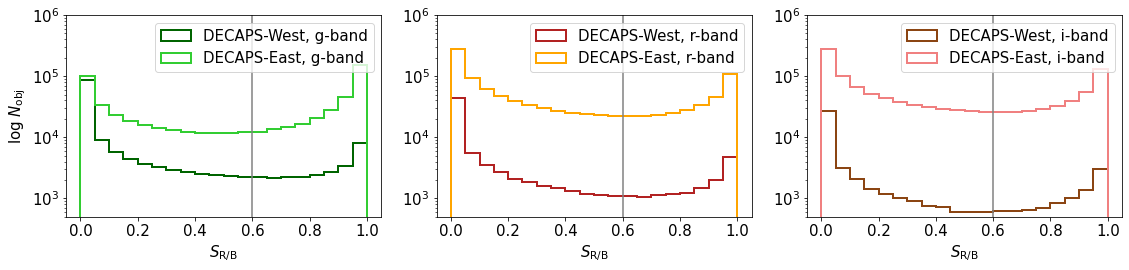

In [43]:
fig, ax = plt.subplots( 1, 3, figsize=(16,4), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    fcx = np.where( exp_fil[ sub_expind[ obj_subind[DWox] ] ] == ifilt )[0]
    ax[i].hist( obj_rb[DWox[fcx]], bins=20, log=True, histtype='step', lw=2, \
               color=c[i], label='DECAPS-West, '+ifilt+'-band')

    j = i + 3
    fex = np.where( exp_fil[ sub_expind[ obj_subind[DEox] ] ] == ifilt )[0]
    ax[i].hist( obj_rb[DEox[fex]], bins=20, log=True, histtype='step', lw=2, \
               color=c[j], label='DECAPS-East, '+ifilt+'-band')
    
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].legend(loc='upper right')
    ax[i].set_ylim([500,1000000])

    if i == 0:
        ax[i].set_ylabel(r'log $N_{\rm obj}$')
    ax[i].set_xlabel(r'$S_{\rm R/B}$')
    ax[i].axvline(0.6, color='grey')

    del fcx
    del fex
    
fig.tight_layout()
plt.savefig("gal_sds_figures/srcdet_RBhist.png")

#### object magnitude distributions per filter

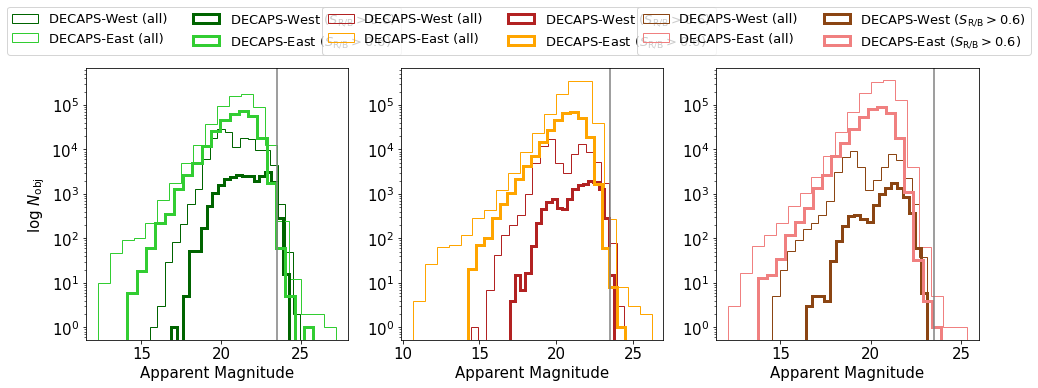

In [67]:
fig, ax = plt.subplots( 1, 3, figsize=(16,5), sharey=True )
for i,ifilt in enumerate(['g','r','i']):
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)

    fcx = np.where( exp_fil[ sub_expind[ obj_subind[DWox] ] ] == ifilt )[0]
    ax[i].hist( obj_mag[DWox[fcx]], bins=20, log=True, histtype='step', lw=1, \
               color=c[i], label='DECAPS-West (all)')
    del fcx
    
    j = i + 3
    fex = np.where( exp_fil[ sub_expind[ obj_subind[DEox] ] ] == ifilt )[0]
    ax[i].hist( obj_mag[DEox[fex]], bins=20, log=True, histtype='step', lw=1, \
               color=c[j], label='DECAPS-East (all)')
    del fex

    fcx = np.where( exp_fil[ sub_expind[ obj_subind[rbg_DWox] ] ] == ifilt )[0]
    ax[i].hist( obj_mag[rbg_DWox[fcx]], bins=20, log=True, histtype='step', lw=3, \
               color=c[i], label=r'DECAPS-West ($S_{\rm R/B}>0.6$)')
    del fcx
    
    j = i + 3
    fex = np.where( exp_fil[ sub_expind[ obj_subind[rbg_DEox] ] ] == ifilt )[0]
    ax[i].hist( obj_mag[rbg_DEox[fex]], bins=20, log=True, histtype='step', lw=3, \
               color=c[j], label=r'DECAPS-East ($S_{\rm R/B}>0.6$)')
    del fex

    if i == 0:
        ax[i].set_ylabel(r'log $N_{\rm obj}$')
    ax[i].set_xlabel("Apparent Magnitude")
    ax[i].axvline(23.5, color='grey')
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.45, 1.25), ncol=2, fontsize=13)

# fig.tight_layout()
plt.savefig("gal_sds_figures/srcdet_maghist.png")

#### real/bogus vs. magnitude

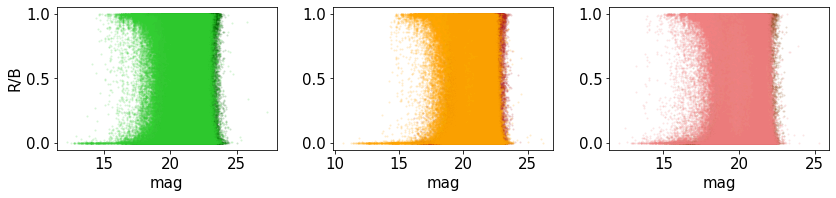

In [45]:
fig, ax = plt.subplots( 1, 3, figsize=(12,3), sharey=True )
for i,ifilt in enumerate(['g','r','i']):

    fcx = np.where( exp_fil[ sub_expind[ obj_subind[DWox] ] ] == ifilt )[0]
    ax[i].plot( obj_mag[DWox[fcx]], obj_rb[DWox[fcx]], 'o', ms=2, alpha=0.2, mew=0, color=c[i])
    del fcx

    j = i + 3
    fex = np.where( exp_fil[ sub_expind[ obj_subind[DEox] ] ] == ifilt )[0]
    ax[i].plot( obj_mag[DEox[fex]], obj_rb[DEox[fex]], 'o', ms=2, alpha=0.2, mew=0, color=c[j])
    del fex

    if i == 0:
        ax[i].set_ylabel("R/B")
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].set_xlabel("mag")

fig.tight_layout()
plt.show()

<br>
<br>

## plot candidate qualities

In [46]:
DWcx = np.where( (cand_ra > 100.0) & (cand_ra < 130.0) & (cand_dec > -30.0)  & (cand_dec < -20.0) )[0]
DEcx = np.where( (cand_ra > 250.0)   & (cand_ra < 300.0)  & (cand_dec > -35.0) & (cand_dec < -25.0) )[0]
print('Number of DECAPS-West candidates: ',len(DWcx))
print('Number of DECAPS-East candidates: ',len(DEcx))

# likely real based on mean real/bogus score
cut_mRB = 0.4
str_cut_mRB = str(cut_mRB)
rbg_DWcx = np.where( (cand_meanrb > cut_mRB) & \
                   (cand_ra > 100.0) & (cand_ra < 130.0) & \
                   (cand_dec > -30.0)  & (cand_dec < -20.0) )[0]
rbg_DEcx = np.where( (cand_meanrb > cut_mRB) & \
                   (cand_ra > 250.0)   & (cand_ra < 300.0)  & \
                   (cand_dec > -35.0) & (cand_dec < -25.0) )[0]
print('Number of DECAPS-West candidates with Mean R/B>'+str_cut_mRB+': ',len(rbg_DWcx),float(len(rbg_DWcx))/float(len(DWcx)) )
print('Number of DECAPS-East candidates with Mean R/B>'+str_cut_mRB+': ',len(rbg_DEcx),float(len(rbg_DEcx))/float(len(DEcx)) )

# likely real based on number of detections
cut_Nobj = 10
str_cut_Nobj = str(cut_Nobj)
rdt_DWcx = np.where( (cand_nobj > cut_Nobj) & \
                   (cand_ra > 100.0) & (cand_ra < 130.0) & \
                   (cand_dec > -30.0)  & (cand_dec < -20.0) )[0]
rdt_DEcx = np.where( (cand_nobj > cut_Nobj) & \
                   (cand_ra > 250.0)   & (cand_ra < 300.0)  & \
                   (cand_dec > -35.0) & (cand_dec < -25.0) )[0]
print('Number of DECAPS-West candidates with nobj>10: ',len(rdt_DWcx),float(len(rdt_DWcx))/float(len(DWcx)))
print('Number of DECAPS-East candidates with nobj>31: ',len(rdt_DEcx),float(len(rdt_DEcx))/float(len(DEcx)))

# likely real based on both mean real/bogus and number of detections = LIKELY GOOD
good_DWcx = np.where( (cand_nobj > cut_Nobj) & (cand_meanrb > cut_mRB) & \
                    (cand_ra > 100.0) & (cand_ra < 130.0) & \
                    (cand_dec > -30.0)  & (cand_dec < -20.0) )[0]
good_DEcx = np.where( (cand_nobj > cut_Nobj) & (cand_meanrb > cut_mRB) & \
                    (cand_ra > 250.0)   & (cand_ra < 300.0) & \
                    (cand_dec > -35.0) & (cand_dec < -25.0) )[0]
print('Number of DECAPS-West candidates that are "good": ',len(good_DWcx),float(len(good_DWcx))/float(len(DWcx)) )
print('Number of DECAPS-East candidates that are "good": ',len(good_DEcx),float(len(good_DEcx))/float(len(DEcx)) )

Number of DECAPS-West candidates:  241657
Number of DECAPS-East candidates:  986003
Number of DECAPS-West candidates with Mean R/B>0.4:  42869 0.17739606135969577
Number of DECAPS-East candidates with Mean R/B>0.4:  287159 0.29123542220459775
Number of DECAPS-West candidates with nobj>10:  870 0.0036001440057602304
Number of DECAPS-East candidates with nobj>31:  39837 0.040402513988294156
Number of DECAPS-West candidates that are "good":  264 0.0010924574914031044
Number of DECAPS-East candidates that are "good":  18798 0.019064850715464356


#### show the spatial distribution of candidates

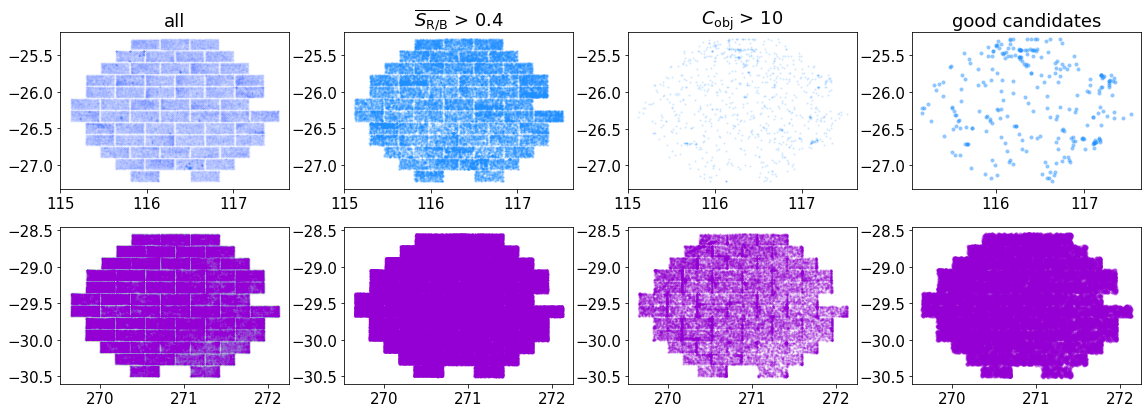

In [47]:
fig, ax = plt.subplots( 2, 4, figsize=(16,6), sharey=False )

ax[0,0].plot( cand_ra[DWcx], cand_dec[DWcx], 'o', ms=2, alpha=0.01, mew=0, color=cc)
ax[0,1].plot( cand_ra[rbg_DWcx], cand_dec[rbg_DWcx], 'o', ms=2, alpha=0.2, mew=0, color=cc)
ax[0,2].plot( cand_ra[rdt_DWcx], cand_dec[rdt_DWcx], 'o', ms=2, alpha=0.2, mew=0, color=cc)
ax[0,3].plot( cand_ra[good_DWcx], cand_dec[good_DWcx], 'o', ms=4, alpha=0.5, mew=0, color=cc)

ax[1,0].plot( cand_ra[DEcx], cand_dec[DEcx], 'o', ms=2, alpha=0.01, mew=0, color=ce)
ax[1,1].plot( cand_ra[rbg_DEcx], cand_dec[rbg_DEcx], 'o', ms=2, alpha=0.2, mew=0, color=ce)
ax[1,2].plot( cand_ra[rdt_DEcx], cand_dec[rdt_DEcx], 'o', ms=2, alpha=0.2, mew=0, color=ce)
ax[1,3].plot( cand_ra[good_DEcx], cand_dec[good_DEcx], 'o', ms=4, alpha=0.5, mew=0, color=ce)

ax[0,0].set_title( 'all' )
ax[0,1].set_title( r'$\overline{S_{\rm R/B}}$ > '+str_cut_mRB )
ax[0,2].set_title( r'$C_{\rm obj}$ > '+str_cut_Nobj )
ax[0,3].set_title( 'good candidates' )
fig.tight_layout()
plt.show()

#### distributions of mean real-bogus and N obj

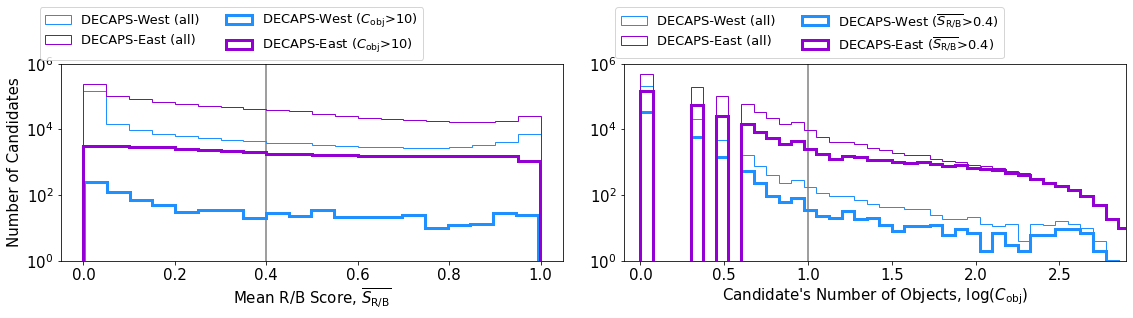

In [48]:
fig, ax = plt.subplots( 1, 2, figsize=(16,5), sharey=True )

ax[0].axvline( cut_mRB, color='grey' )
ax[0].hist( cand_meanrb[DWcx],     bins=20, log=True, histtype='step', lw=1, color=cc, \
           label='DECAPS-West (all)')
ax[0].hist( cand_meanrb[DEcx],     bins=20, log=True, histtype='step', lw=1, color=ce, \
           label='DECAPS-East (all)')
ax[0].hist( cand_meanrb[rdt_DWcx], bins=20, log=True, histtype='step', lw=3, color=cc, \
           label=r'DECAPS-West ($C_{\rm obj}$>'+str_cut_Nobj+')')
ax[0].hist( cand_meanrb[rdt_DEcx], bins=20, log=True, histtype='step', lw=3, color=ce, \
           label=r'DECAPS-East ($C_{\rm obj}$>'+str_cut_Nobj+')')
ax[0].set_xlabel(r'Mean R/B Score, $\overline{S_{\rm R/B}}$')
ax[0].set_ylabel("Number of Candidates")

ax[1].axvline( np.log10(cut_Nobj), color='grey' )
ax[1].hist( np.log10(cand_nobj[DWcx]),     bins=40, range=(0,3.0), log=True, \
           histtype='step', lw=1, color=cc, label='DECAPS-West (all)')
ax[1].hist( np.log10(cand_nobj[DEcx]),     bins=40, range=(0,3.0), log=True, \
           histtype='step', lw=1, color=ce, label='DECAPS-East (all)')
ax[1].hist( np.log10(cand_nobj[rbg_DWcx]), bins=40, range=(0,3.0), log=True, \
           histtype='step', lw=3, color=cc, label=r'DECAPS-West ($\overline{S_{\rm R/B}}$>'+str_cut_mRB+')')
ax[1].hist( np.log10(cand_nobj[rbg_DEcx]), bins=40, range=(0,3.0), log=True, \
           histtype='step', lw=3, color=ce, label=r'DECAPS-East ($\overline{S_{\rm R/B}}$>'+str_cut_mRB+')')
ax[1].set_xlabel(r"Candidate's Number of Objects, log($C_{\rm obj}$)")
ax[1].set_xlim([-0.1,2.9])
# ax[1].set_ylabel("Number of Candidates")

ax[1].set_ylim([1,1000000])

for i in (0,1):
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
ax[0].legend(loc='upper center', bbox_to_anchor=(0.34, 1.32), ncol=2, fontsize=13)
ax[1].legend(loc='upper center', bbox_to_anchor=(0.37, 1.32), ncol=2, fontsize=13)

fig.tight_layout()
plt.savefig("gal_sds_figures/srcdet_candhists.png")

#### std in rb and Nobj vs. mean real-bogus

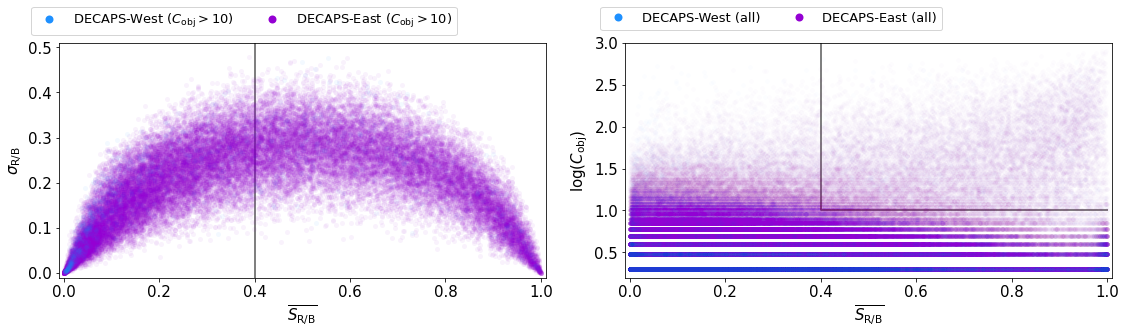

In [70]:
fig, ax = plt.subplots( 1, 2, figsize=(16,5), sharey=False )

ax[0].axvline( cut_mRB, lw=2, color='grey' )
ax[0].yaxis.set_tick_params(which='both', labelbottom=True)
ax[0].plot( cand_meanrb[rdt_DEcx], cand_stdrb[rdt_DEcx], 'o', ms=5, \
           alpha=0.05, mew=0, color=ce)#, label=r'DECAPS-East ($N_{\rm obj}>10$)')
ax[0].plot( cand_meanrb[rdt_DWcx], cand_stdrb[rdt_DWcx], 'o', ms=5, \
           alpha=0.05, mew=0, color=cc)#, label=r'DECAPS-West ($N_{\rm obj}>10$)')
ax[0].set_xlabel(r'$\overline{S_{\rm R/B}}$')
ax[0].set_ylabel(r'$\sigma_{\rm R/B}$')
ax[0].set_xlim([-0.01,1.01])
ax[0].set_ylim([-0.01,0.51])
ax[0].plot(-99,-99, 'o', ms=8, alpha=1, mew=0, color=cc, label=r'DECAPS-West ($C_{\rm obj}>$'+str_cut_Nobj+')')
ax[0].plot(-99,-99, 'o', ms=8, alpha=1, mew=0, color=ce, label=r'DECAPS-East ($C_{\rm obj}>$'+str_cut_Nobj+')')
ax[0].legend(loc='upper center', bbox_to_anchor=(0.38, 1.18), ncol=2, fontsize=13)

# ax[1].axvline( cut_mRB, color='grey' )
# ax[1].axhline( np.log10(cut_Nobj), color='grey' )
ax[1].plot( [cut_mRB,cut_mRB,1.0],[3.0,np.log10(cut_Nobj),np.log10(cut_Nobj)], lw=2, color='grey')
# ax[1].plot( cand_meanrb[rdt_DWcx], np.log10(cand_nobj[rdt_DWcx]), 'o', ms=5, \
#            alpha=0.1, mew=0, color=cc)#, label=r'DECAPS-West ($N_{\rm obj}>10$)')
# ax[1].plot( cand_meanrb[rdt_DEcx], np.log10(cand_nobj[rdt_DEcx]), 'o', ms=5, \
#            alpha=0.1, mew=0, color=ce)#, label=r'DECAPS-East ($N_{\rm obj}>10$)')
ax[1].plot( cand_meanrb[DEcx], np.log10(cand_nobj[DEcx]), 'o', ms=5, \
           alpha=0.01, mew=0, color=ce)#, label=r'DECAPS-East ($N_{\rm obj}>10$)')
ax[1].plot( cand_meanrb[DWcx], np.log10(cand_nobj[DWcx]), 'o', ms=5, \
           alpha=0.01, mew=0, color=cc)#, label=r'DECAPS-West ($N_{\rm obj}>10$)')
ax[1].set_xlabel(r'$\overline{S_{\rm R/B}}$')
ax[1].set_ylabel(r"log($C_{\rm obj}$)")
ax[1].set_xlim([-0.01,1.01])
# ax[1].set_ylim([0.99,3.0])
ax[1].set_ylim([0.2,3.0])
# ax[1].plot(-99,-99, 'o', ms=8, alpha=1, mew=0, color=cc, label=r'DECAPS-West ($C_{\rm obj}>10$)')
# ax[1].plot(-99,-99, 'o', ms=8, alpha=1, mew=0, color=ce, label=r'DECAPS-East ($C_{\rm obj}>10$)')
ax[1].plot(-99,-99, 'o', ms=8, alpha=1, mew=0, color=cc, label=r'DECAPS-West (all)')
ax[1].plot(-99,-99, 'o', ms=8, alpha=1, mew=0, color=ce, label=r'DECAPS-East (all)')
ax[1].legend(loc='upper center', bbox_to_anchor=(0.3, 1.18), ncol=2, fontsize=13)

# ax[1].axvline( np.log10(cut_Nobj), color='grey' )
# ax[1].plot( np.log10(cand_nobj[rbg_DWcx]), cand_stdrb[rbg_DWcx], 'o', ms=5, \
#            alpha=0.1, mew=0, color=cc)#, label=r'DECAPS-West ($N_{\rm obj}>10$)')
# ax[1].plot( np.log10(cand_nobj[rbg_DEcx]), cand_stdrb[rbg_DEcx], 'o', ms=5, \
#            alpha=0.1, mew=0, color=ce)#, label=r'DECAPS-East ($N_{\rm obj}>10$)')
# ax[1].set_xlabel(r"log($C_{\rm obj}$)")
# ax[1].set_ylabel(r'$\sigma_{\rm R/B}$')
# ax[1].set_xlim([0.2,3.0])
# ax[1].set_ylim([-0.01,0.51])
# ax[1].plot(-99,-99, 'o', ms=8, alpha=1, mew=0, color=cc, label=r'DECAPS-West ($\overline{S_{\rm R/B}}>0.4$)')
# ax[1].plot(-99,-99, 'o', ms=8, alpha=1, mew=0, color=ce, label=r'DECAPS-East ($\overline{S_{\rm R/B}}>0.4$)')
# ax[1].legend(loc='upper center', bbox_to_anchor=(0.38, 1.18), ncol=2, fontsize=13)

ax[0].yaxis.set_tick_params(which='both', labelbottom=True)
ax[1].yaxis.set_tick_params(which='both', labelbottom=True)

fig.tight_layout()
plt.savefig("./gal_sds_figures/srcdet_vsmeanrb.png")

#### candidate qualities histograms

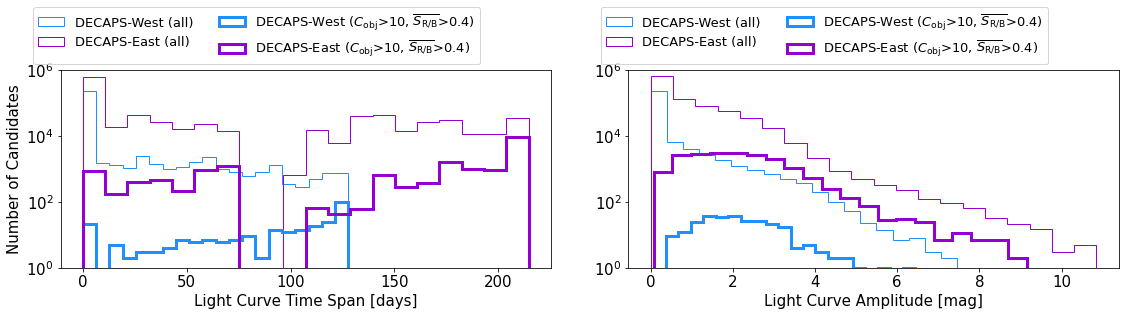

In [50]:
fig, ax = plt.subplots( 1, 2, figsize=(16,5), sharey=True )

ax[0].hist( cand_tspan[DWcx], bins=20, log=True, histtype='step', lw=1, color=cc, \
           label='DECAPS-West (all)')
ax[0].hist( cand_tspan[DEcx], bins=20, log=True, histtype='step', lw=1, color=ce, \
           label='DECAPS-East (all)')
ax[0].hist( cand_tspan[good_DWcx], bins=20, log=True, histtype='step', lw=3, color=cc, \
           label=r'DECAPS-West ($C_{\rm obj}$>'+str_cut_Nobj+r', $\overline{S_{\rm R/B}}$>'+str_cut_mRB+')')
ax[0].hist( cand_tspan[good_DEcx], bins=20, log=True, histtype='step', lw=3, color=ce, \
           label=r'DECAPS-East ($C_{\rm obj}$>'+str_cut_Nobj+r', $\overline{S_{\rm R/B}}$>'+str_cut_mRB+')')
ax[0].set_xlabel("Light Curve Time Span [days]")
ax[0].set_ylabel("Number of Candidates")

ax[1].hist( cand_lcamp[DWcx], bins=20, log=True, histtype='step', lw=1, color=cc, \
           label='DECAPS-West (all)')
ax[1].hist( cand_lcamp[DEcx], bins=20, log=True, histtype='step', lw=1, color=ce, \
           label='DECAPS-East (all)')
ax[1].hist( cand_lcamp[good_DWcx], bins=20, log=True, histtype='step', lw=3, color=cc, \
           label=r'DECAPS-West ($C_{\rm obj}$>'+str_cut_Nobj+r', $\overline{S_{\rm R/B}}$>'+str_cut_mRB+')')
ax[1].hist( cand_lcamp[good_DEcx], bins=20, log=True, histtype='step', lw=3, color=ce, \
           label=r'DECAPS-East ($C_{\rm obj}$>'+str_cut_Nobj+r', $\overline{S_{\rm R/B}}$>'+str_cut_mRB+')')
ax[1].set_xlabel("Light Curve Amplitude [mag]")
# ax[row,1].set_ylabel("Number of Candidates")

ax[0].set_ylim([1,10e5])

ax[0].yaxis.set_tick_params(which='both', labelbottom=True)
ax[1].yaxis.set_tick_params(which='both', labelbottom=True)
ax[0].legend(loc='upper center', bbox_to_anchor=(0.4, 1.35), ncol=2, fontsize=13)
ax[1].legend(loc='upper center', bbox_to_anchor=(0.4, 1.35), ncol=2, fontsize=13)

fig.tight_layout()
# plt.show()
plt.savefig("gal_sds_figures/srcdet_candchar.png")

In [51]:
### same as above, but by filter

# fig, ax = plt.subplots( 1, 2, figsize=(16,3), sharey=True )

# for i in range(3):
#     j = i + 3
#     ax[0].hist( cand_tspan_f[good_DWcx,i], bins=20, log=True, histtype='step', lw=1, color=c[i])#, label='DECAPS-West (good)')
#     ax[0].hist( cand_tspan_f[good_DEcx,i], bins=20, log=True, histtype='step', lw=1, color=c[j])#, label='DECAPS-East (good)')
# ax[0].set_xlabel("Light Curve Time Span [days]")
# ax[0].set_ylabel("Number of Candidates")

# for i in range(3):
#     j = i + 3
#     ax[1].hist( cand_lcamp_f[good_DWcx,i], bins=20, log=True, histtype='step', lw=1, color=c[i])#, label='DECAPS-West (good)')
#     ax[1].hist( cand_lcamp_f[good_DEcx,i], bins=20, log=True, histtype='step', lw=1, color=c[j])#, label='DECAPS-East (good)')
# ax[1].set_xlabel("Light Curve Amplitude [mag]")

# fig.tight_layout()
# plt.show()
# # plt.savefig("gal_sds_figures/.png")

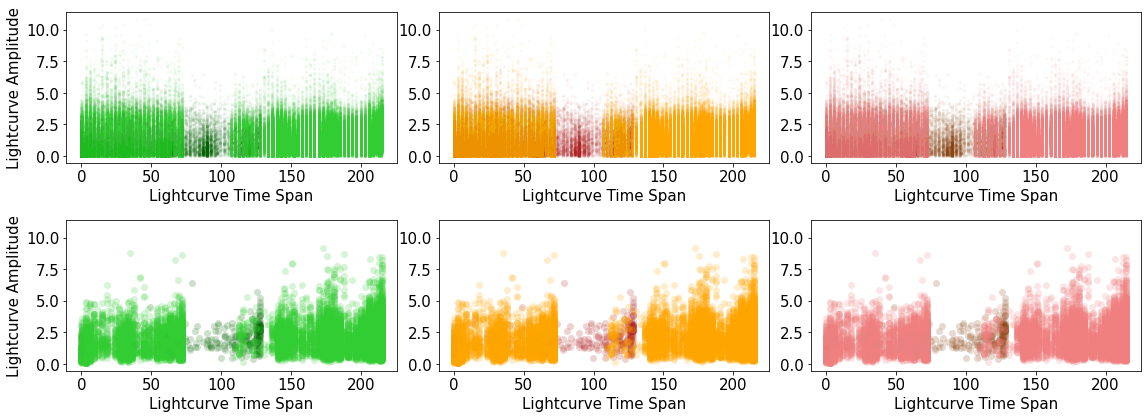

In [52]:
fig, ax = plt.subplots( 2, 3, figsize=(16,6), sharey=True )

for i in range(3):
    j = i + 3
    ax[0,i].plot( cand_tspan[DWcx], cand_lcamp[DWcx], 'o', ms=3, \
               alpha=0.05, mew=0, color=c[i], label='DECAPS-West (all)')
    ax[0,i].plot( cand_tspan[DEcx], cand_lcamp[DEcx], 'o', ms=3, \
               alpha=0.05, mew=0, color=c[j], label='DECAPS-East (all)')

    ax[0,i].set_xlabel("Lightcurve Time Span")
    ax[0,i].yaxis.set_tick_params(which='both', labelbottom=True)
ax[0,0].set_ylabel("Lightcurve Amplitude")

for i in range(3):
    j = i + 3
    ax[1,i].plot( cand_tspan[good_DWcx], cand_lcamp[good_DWcx], 'o', ms=7, \
               alpha=0.2, mew=0, color=c[i], label='DECAPS-West (good)')
    ax[1,i].plot( cand_tspan[good_DEcx], cand_lcamp[good_DEcx], 'o', ms=7, \
               alpha=0.2, mew=0, color=c[j], label='DECAPS-East (good)')

    ax[1,i].set_xlabel("Lightcurve Time Span")
    ax[1,i].yaxis.set_tick_params(which='both', labelbottom=True)
ax[1,0].set_ylabel("Lightcurve Amplitude")

# ax[1].yaxis.set_tick_params(which='both', labelbottom=True)

fig.tight_layout()
plt.show()
# plt.savefig("./gal_sds_figures/.png")

<br>
<br>


## Create Candidate Summary Files

just for our 'interesting' candidates

#### create a file listing all 'interesting' candidates and their properties

In [53]:
fnm = 'gal_sds_files/candidates.dat'
fout = open(fnm, 'w')

fout.write('# Melissa Graham, gal_sds.ipynb \n')
tnow = time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime())
fout.write('# UTC = '+tnow+' \n')
del tnow
fout.write('# \n')
fout.write('# Columns \n')
fout.write('#  0 field  \n')
fout.write('#  1 id  \n')
fout.write('#  2 ra  \n')
fout.write('#  3 dec \n')
fout.write('#  4 Cobj   -- number of objects (detections) \n')
fout.write('#  5 meanRB -- mean of all objects R/B scores \n')
fout.write('#  6 stdRB  -- standard deviation of all objects R/B scores \n')
fout.write('#  7 tspan  -- time span (max-min MJD) \n')
fout.write('#  8 lcamp  -- amplitude (max-min mag, any filter) \n')
fout.write('#  9 Cobj   g-band \n')
fout.write('# 10 meanRB g-band \n')
fout.write('# 11 stdRB  g-band \n')
fout.write('# 12 tspan  g-band \n')
fout.write('# 13 lcamp  g-band \n')
fout.write('# 14 Cobj   r-band \n')
fout.write('# 15 meanRB r-band \n')
fout.write('# 16 stdRB  r-band \n')
fout.write('# 17 tspan  r-band \n')
fout.write('# 18 lcamp  r-band \n')
fout.write('# 19 Cobj   i-band \n')
fout.write('# 20 meanRB i-band \n')
fout.write('# 21 stdRB  i-band \n')
fout.write('# 22 tspan  i-band \n')
fout.write('# 23 lcamp  i-band \n')
fout.write('# \n')

for i in good_DWcx:
    fout.write('DECAPS-West %-9s %15.11f %16.11f '\
               '%4i %11.9f %11.9f %9.5f %6.3f '\
               '%4i %11.9f %11.9f %9.5f %6.3f '\
               '%4i %11.9f %11.9f %9.5f %6.3f '\
               '%4i %11.9f %11.9f %9.5f %6.3f \n' % \
               (cand_id[i],cand_ra[i],cand_dec[i],\
                cand_nobj[i],cand_meanrb[i],cand_stdrb[i],cand_tspan[i],cand_lcamp[i],\
                cand_nobj_f[i,0],cand_meanrb_f[i,0],cand_stdrb_f[i,0],cand_tspan_f[i,0],cand_lcamp_f[i,0],\
                cand_nobj_f[i,1],cand_meanrb_f[i,1],cand_stdrb_f[i,1],cand_tspan_f[i,1],cand_lcamp_f[i,1],\
                cand_nobj_f[i,2],cand_meanrb_f[i,2],cand_stdrb_f[i,2],cand_tspan_f[i,2],cand_lcamp_f[i,2]))

for i in good_DEcx:
    fout.write('DECAPS-East %-9s %15.11f %16.11f '\
               '%4i %11.9f %11.9f %9.5f %6.3f '\
               '%4i %11.9f %11.9f %9.5f %6.3f '\
               '%4i %11.9f %11.9f %9.5f %6.3f '\
               '%4i %11.9f %11.9f %9.5f %6.3f \n' % \
               (cand_id[i],cand_ra[i],cand_dec[i],\
                cand_nobj[i],cand_meanrb[i],cand_stdrb[i],cand_tspan[i],cand_lcamp[i],\
                cand_nobj_f[i,0],cand_meanrb_f[i,0],cand_stdrb_f[i,0],cand_tspan_f[i,0],cand_lcamp_f[i,0],\
                cand_nobj_f[i,1],cand_meanrb_f[i,1],cand_stdrb_f[i,1],cand_tspan_f[i,1],cand_lcamp_f[i,1],\
                cand_nobj_f[i,2],cand_meanrb_f[i,2],cand_stdrb_f[i,2],cand_tspan_f[i,2],cand_lcamp_f[i,2]))

fout.close()
print('wrote to: ',fnm)
del fnm,fout

wrote to:  gal_sds_files/candidates.dat


#### create exposure lists (e.g., limiting magnitudes for all caldates)

In [54]:
# print(exp_cal[e], exp_fbs[e], exp_id[e], exp_mjd[e], exp_fil[e], \
#       exp_mlmg[e], exp_msee[e], exp_msks[e], exp_tnobj[e], exp_tnobjg[e])

# print( '%7i %23s %6i %14.8f %1s %6.3f %5.3f %8.3f %6i %6i \n' % \
#       (exp_cal[e], exp_fbs[e], exp_id[e], exp_mjd[e], exp_fil[e], \
#        exp_mlmg[e], exp_msee[e], exp_msks[e], exp_tnobj[e], exp_tnobjg[e]) )

In [55]:
### recall these are defined:
# DWex = np.where( (exp_ra > 100.0) & (exp_ra < 130.0) & (exp_dec > -30.0)  & (exp_dec < -20.0) )[0]
# DEex = np.where( (exp_ra > 250.0)   & (exp_ra < 300.0)  & (exp_dec > -35.0) & (exp_dec < -25.0) )[0]

sDWex = np.argsort( exp_mjd[DWex] )
sDEex = np.argsort( exp_mjd[DEex] )

fnm = 'gal_sds_files/exposures_DECAPS-West.dat'
fout = open(fnm, 'w')
fout.write('# Melissa Graham, gal_sds.ipynb \n')
tnow = time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime())
fout.write('# UTC = '+tnow+' \n')
del tnow
fout.write('# \n')
fout.write('# Columns \n')
fout.write('#  0 exposure calendar date \n')
fout.write('#  1 filename base \n')
fout.write('#  2 exposure identifier \n')
fout.write('#  3 modified julian date \n')
fout.write('#  4 filter \n')
fout.write('#  5 mean limiting magnitude (over all subtractions) \n')
fout.write('#  6 mean seeing (over all subtractions) \n')
fout.write('#  7 mean sky background (over all subtractions) \n')
fout.write('#  8 total number of objects \n')
fout.write('#  9 total number of objects with R/B>0.6 \n')
fout.write('# \n')
for i in range(len(DWex)):
    e = DWex[sDWex[i]]
    fout.write( '%7i %23s %6i %14.8f %1s %6.3f %5.3f %8.3f %6i %6i \n' % \
               (exp_cal[e], exp_fbs[e], exp_id[e], exp_mjd[e], exp_fil[e], \
                exp_mlmg[e], exp_msee[e], exp_msks[e], exp_tnobj[e], exp_tnobjg[e]) )
fout.close()
print('wrote to ',fnm)
del fnm,fout

fnm = 'gal_sds_files/exposures_DECAPS-East.dat'
fout = open(fnm, 'w')
fout.write('# Melissa Graham, gal_sds.ipynb \n')
tnow = time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime())
fout.write('# UTC = '+tnow+' \n')
del tnow
fout.write('# \n')
fout.write('# Columns \n')
fout.write('#  0 exposure calendar date \n')
fout.write('#  1 filename base \n')
fout.write('#  2 exposure identifier \n')
fout.write('#  3 modified julian date \n')
fout.write('#  4 filter \n')
fout.write('#  5 mean limiting magnitude (over all subtractions) \n')
fout.write('#  6 mean seeing (over all subtractions) \n')
fout.write('#  7 mean sky background (over all subtractions) \n')
fout.write('#  8 total number of objects \n')
fout.write('#  9 total number of objects with R/B>0.6 \n')
fout.write('# \n')
for i in range(len(DEex)):
    e = DEex[sDEex[i]]
    fout.write( '%7i %23s %6i %14.8f %1s %6.3f %5.3f %8.3f %6i %6i \n' % \
               (exp_cal[e], exp_fbs[e], exp_id[e], exp_mjd[e], exp_fil[e], \
                exp_mlmg[e], exp_msee[e], exp_msks[e], exp_tnobj[e], exp_tnobjg[e]) )
fout.close()
print('wrote to ',fnm)
del fnm,fout

wrote to  gal_sds_files/exposures_DECAPS-West.dat
wrote to  gal_sds_files/exposures_DECAPS-East.dat


#### create lightcurve files for each candidate

In [56]:
print('the total number of files made would be:', len(good_DWcx)+len(good_DEcx) )
print('the total number of rows printed would be:', np.sum(cand_nobj[good_DWcx])+np.sum(cand_nobj[good_DEcx]) )

the total number of files made would be: 19062
the total number of rows printed would be: 1199750


In [77]:
len(good_DWcx), len(good_DEcx)

(264, 18798)

In [66]:
t1 = time.time()

### recall these are already defined
# good_DWcx = np.where( (cand_nobj > cut_Nobj) & (cand_meanrb > cut_mRB) & \
#                     (cand_ra > 100.0) & (cand_ra < 130.0) & \
#                     (cand_dec > -30.0)  & (cand_dec < -20.0) )[0]
# good_DEcx = np.where( (cand_nobj > cut_Nobj) & (cand_meanrb > cut_mRB) & \
#                     (cand_ra > 250.0)   & (cand_ra < 300.0) & \
#                     (cand_dec > -35.0) & (cand_dec < -25.0) )[0]

fnm = 'gal_sds_files/lightcurves_DECAPS-West.dat'
fout = open(fnm, 'w')
fout.write('# Melissa Graham, gal_sds.ipynb \n')
tnow = time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime())
fout.write('# UTC = '+tnow+' \n')
del tnow
fout.write('# \n')
fout.write('# Columns \n')
fout.write('#  0 candidate id \n')
fout.write('#  1 object id \n')
fout.write('#  2 object ra \n')
fout.write('#  3 object dec \n')
fout.write('#  4 object MJD \n')
fout.write('#  5 object filter \n')
fout.write('#  6 object magnitude \n')
fout.write('#  7 object magnitude error \n')
fout.write('#  8 object real/bogus score \n')
fout.write('# \n')
for i in good_DWcx:
    ox = np.where( obj_candid == cand_id[i] )[0]
    sx = np.argsort( obj_mjd[ox] )
    for j in range(len(ox)):
        k = ox[sx[j]]
        fout.write('%-9s %-9s %15.11f %16.11f '\
                   '%14.8f %1s %6.3f %6.3f %6.3f \n' % \
                   (cand_id[i],obj_id[k],obj_ra[k],obj_dec[k],\
                    obj_mjd[k],obj_fil[k],obj_mag[k],obj_magerr[k],obj_rb[k]))
    del ox,sx
fout.close()
print('wrote to: ',fnm)
del fnm,fout
t2 = time.time()
print('elapsed: ',t2-t1)

# fnm = 'gal_sds_files/lightcurves_DECAPS-East.dat'
# fout = open(fnm, 'w')
# fout.write('# Melissa Graham, gal_sds.ipynb \n')
# tnow = time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime())
# fout.write('# UTC = '+tnow+' \n')
# del tnow
# fout.write('# \n')
# fout.write('# Columns \n')
# fout.write('#  0 candidate id \n')
# fout.write('#  1 object id \n')
# fout.write('#  2 object ra \n')
# fout.write('#  3 object dec \n')
# fout.write('#  4 object MJD \n')
# fout.write('#  5 object filter \n')
# fout.write('#  6 object magnitude \n')
# fout.write('#  7 object magnitude error \n')
# fout.write('#  8 object real/bogus score \n')
# fout.write('# \n')
# for i in good_DEcx:
#     ox = np.where( obj_candid == cand_id[i] )[0]
#     sx = np.argsort( obj_mjd[ox] )
#     for j in range(len(ox)):
#         k = ox[sx[j]]
#         fout.write('%-9s %-9s %15.11f %16.11f '\
#                    '%14.8f %1s %6.3f %6.3f %6.3f \n' % \
#                    (cand_id[i],obj_id[k],obj_ra[k],obj_dec[k],\
#                     obj_mjd[k],obj_fil[k],obj_mag[k],obj_magerr[k],obj_rb[k]))
#     del ox,sx
# fout.close()
# print('wrote to: ',fnm)
# del fnm,fout
# t3 = time.time()
# print('elapsed: ',t3-t1)

wrote to:  gal_sds_files/lightcurves_DECAPS-West.dat
elapsed:  21.960021257400513
